<a href="https://colab.research.google.com/github/buadeoye/russo_ukraine_dataset/blob/main/BERT_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
#!pip install -q -U watermark

In [61]:
#!pip install -qq transformers

In [62]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.1+cu113
transformers: 4.21.1



In [63]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [64]:
#Data Exploration

In [65]:
df = pd.read_csv("/content/Russia_Ukraine_Sentiment_Data.csv", encoding = 'ISO-8859-1')
df.head()

,Document,NEGATIVE+Sum(TF abs),POSITIVE+Sum(TF abs),Sentiment Score,Sentiment Prediction,Document class
0,"""I hope Edward Snowden is ok and managed to le...",0,2,1.000000,positive,I hope Edward Snowden is ok and managed to lea...
1,"""There has been an internecine war in #Ukraine...",6,4,-0.200000,negative,There has been an internecine war in #Ukraine ...
2,"""@Masterfrogg @kjdonkers @SteIIa_Maris @Prison...",4,2,-0.333333,negative,@Masterfrogg @kjdonkers @SteIIa_Maris @PrisonP...
3,"""Last week a majority of Americans Did Not wan...",10,4,-0.428571,negative,Last week a majority of Americans Did Not want...
4,"""Ukraine war: The TikToker spreading viral vid...",2,0,-1.000000,negative,Ukraine war: The TikToker spreading viral vide...


In [66]:
df.rename(columns ={'Document': 'document','NEGATIVE+Sum(TF abs)': 'negative_sum_tf','POSITIVE+Sum(TF abs)': 'positive_sum_tf', 'Sentiment Score': 'sentiment_score', 'Sentiment Prediction': 'sentiment_prediction', 'Document class' : 'document_class'}, inplace = True )

In [67]:
df.head()

,document,negative_sum_tf,positive_sum_tf,sentiment_score,sentiment_prediction,document_class
0,"""I hope Edward Snowden is ok and managed to le...",0,2,1.000000,positive,I hope Edward Snowden is ok and managed to lea...
1,"""There has been an internecine war in #Ukraine...",6,4,-0.200000,negative,There has been an internecine war in #Ukraine ...
2,"""@Masterfrogg @kjdonkers @SteIIa_Maris @Prison...",4,2,-0.333333,negative,@Masterfrogg @kjdonkers @SteIIa_Maris @PrisonP...
3,"""Last week a majority of Americans Did Not wan...",10,4,-0.428571,negative,Last week a majority of Americans Did Not want...
4,"""Ukraine war: The TikToker spreading viral vid...",2,0,-1.000000,negative,Ukraine war: The TikToker spreading viral vide...


In [68]:
df.shape

(22409, 6)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22409 entries, 0 to 22408
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   document              22409 non-null  object 
 1   negative_sum_tf       22409 non-null  int64  
 2   positive_sum_tf       22409 non-null  int64  
 3   sentiment_score       22409 non-null  float64
 4   sentiment_prediction  22409 non-null  object 
 5   document_class        22409 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 1.0+ MB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


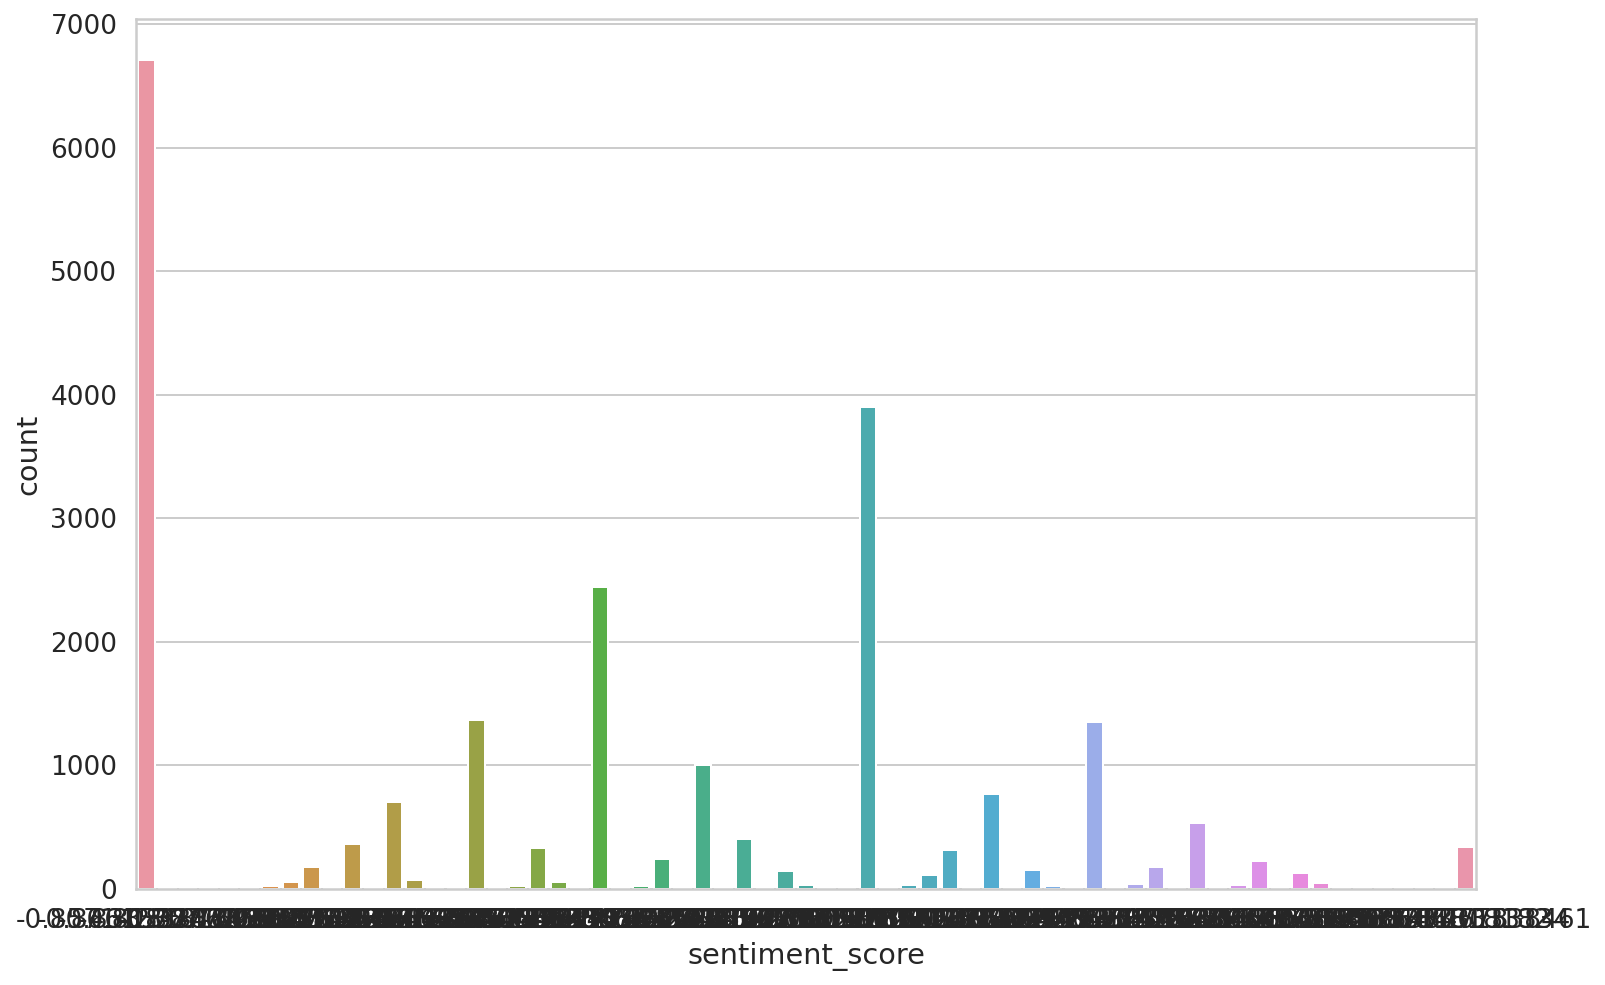

In [70]:
sns.countplot(df.sentiment_score)
plt.xlabel('sentiment_score');

In [71]:
def to_sentiment(rating):
  rating = int(rating)
  if rating < 0:
    return 1
  elif rating == 0:
    return 0
  else: 
    return 2

df['sentiment'] = df.sentiment_score.apply(to_sentiment)

In [72]:
class_names = ['negative', 'neutral', 'positive']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


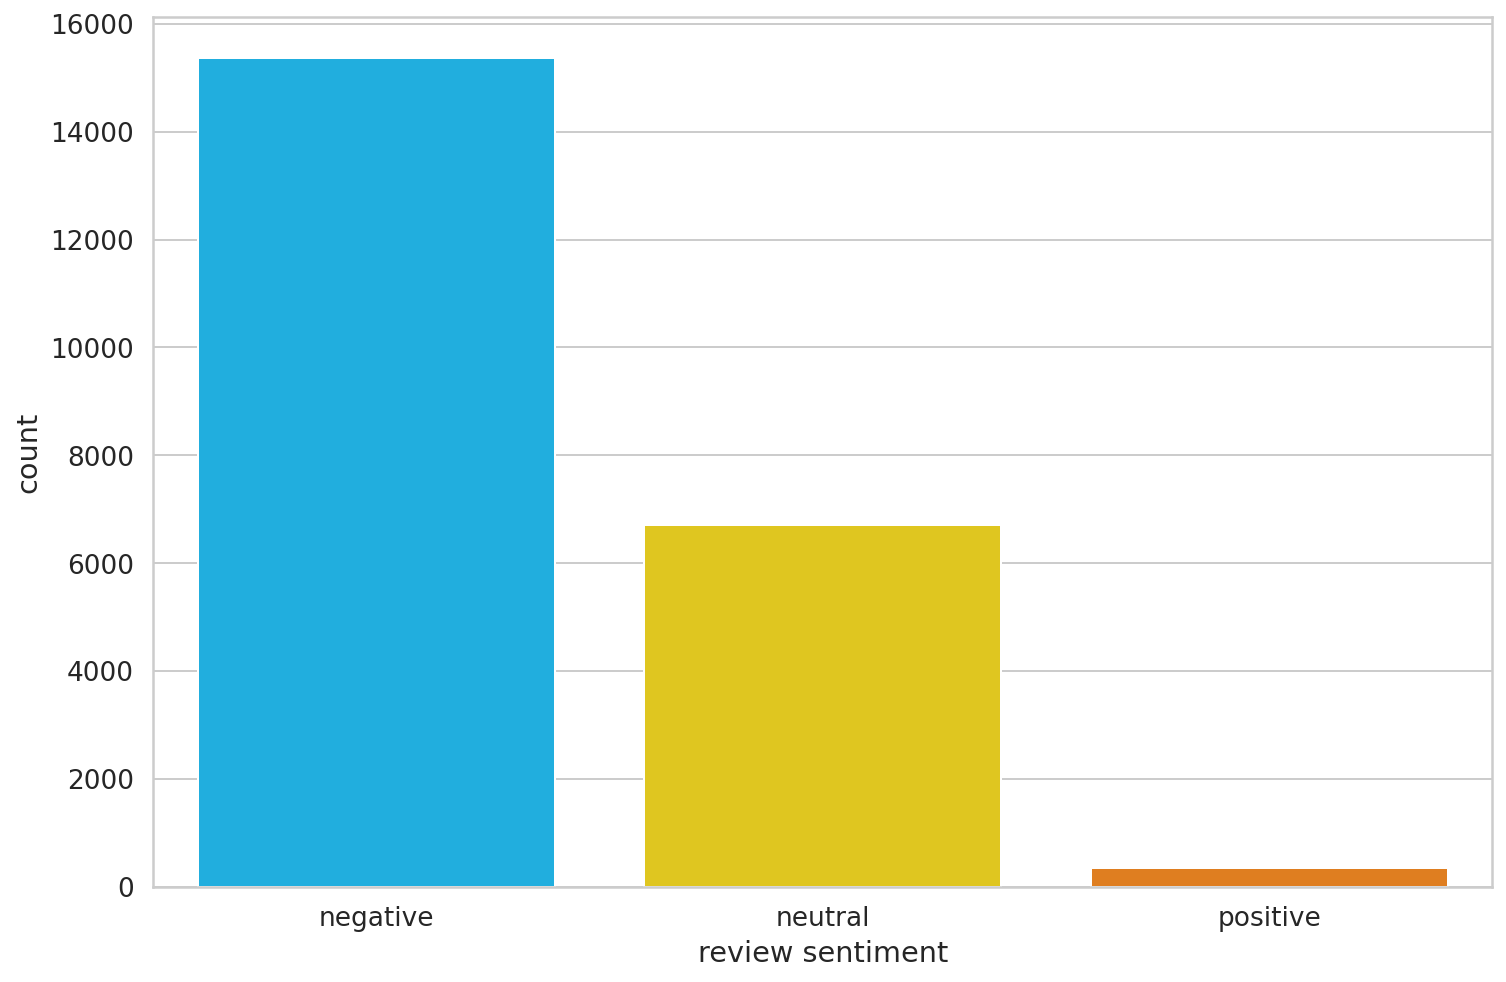

In [73]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [74]:
# Data Preprocessing

In [75]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [76]:
sample_txt = 'Great is thy faithfulness'

In [77]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [78]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Great is thy faithfulness
   Tokens: ['Great', 'is', 'thy', 'faithful', '##ness']
Token IDs: [2038, 1110, 21153, 12969, 1757]


In [79]:
#Special Tokens

In [80]:
tokenizer.sep_token, tokenizer.sep_token_id # [SEP] - marker for ending of a sentence

('[SEP]', 102)

In [81]:
tokenizer.cls_token, tokenizer.cls_token_id # [CLS] - we must add this token to the start of each sentence, so BERT knows we're doing classification

('[CLS]', 101)

In [82]:
tokenizer.pad_token, tokenizer.pad_token_id # [PAD] There is also a special token for padding

('[PAD]', 0)

In [83]:
tokenizer.unk_token, tokenizer.unk_token_id # BERT understands tokens that were in the training set. Everything else can be encoded using the [UNK] (unknown) token

('[UNK]', 100)

In [84]:
#Using Encoding_plus to define a function for the special tokens

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [85]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2038,  1110, 21153, 12969,  1757,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [86]:
# Inverse the tokens

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'Great',
 'is',
 'thy',
 'faithful',
 '##ness',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [87]:
#Choosing Sequence Length
#BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length.

token_lens = []

for txt in df.document:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


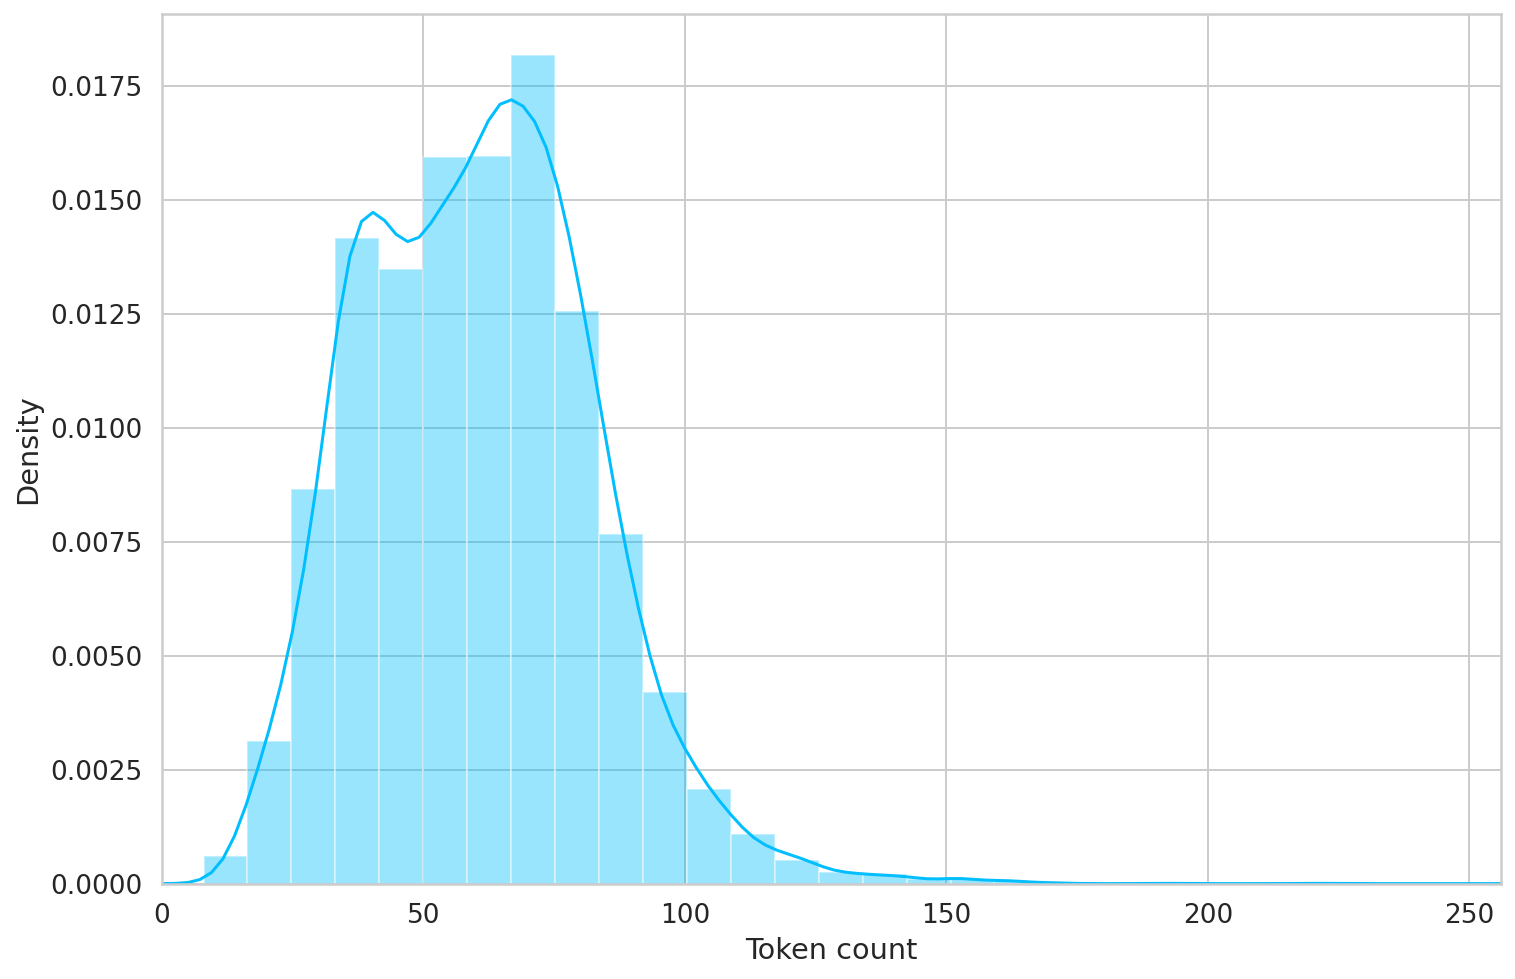

In [90]:
#Plot the distribution of the document toekns

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [91]:
MAX_LEN = 150

In [92]:
#Creating a Pytorch Dataset

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      #pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


    encoding = self.tokenizer.encode_plus(
    poem,
    add_special_tokens=True,
    max_length=self.max_len,
    return_token_type_ids=False,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [93]:
# Creating the model

df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [94]:
df_train.shape, df_val.shape, df_test.shape

((20168, 7), (1120, 7), (1121, 7))

In [95]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.document.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [96]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [97]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [42]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


In [98]:
# Sentiment Classification with BERT and Hugging Face

bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [99]:
# The last_hidden_state is a sequence of hidden states of the last layer of the model. 
# Obtaining the pooled_output is done by applying the BertPooler on last_hidden_state:


last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [100]:

# We can verify that by checking the config:

#last_hidden_state.shape

In [101]:
# We have the hidden state for each of our 32 tokens. This is the number of hidden units in the feedforward-networks is 768. 

bert_model.config.hidden_size

768

In [102]:
# Shape of the output

#pooled_output.shape

In [103]:
# Our classifier delegates most of the heavy lifting to the BertModel. 
# We use a dropout layer for some regularization and a fully-connected layer for our output. 
# Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.



class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict = False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [104]:
# Create an instance and move it to the GPU

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [105]:
# move the example batch of our training data to the GPU

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


In [106]:
# Obtaining the predicted probabilities for the model

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1844, 0.3832, 0.4324],
        [0.1913, 0.3257, 0.4830],
        [0.3133, 0.3747, 0.3120],
        [0.3243, 0.2670, 0.4087],
        [0.3029, 0.3891, 0.3080],
        [0.2013, 0.3909, 0.4078],
        [0.3208, 0.2293, 0.4499],
        [0.1863, 0.2371, 0.5766],
        [0.2854, 0.3983, 0.3162],
        [0.1470, 0.4986, 0.3544],
        [0.2250, 0.2647, 0.5103],
        [0.2105, 0.4326, 0.3568],
        [0.1802, 0.3536, 0.4662],
        [0.2062, 0.2597, 0.5342],
        [0.1823, 0.2933, 0.5244],
        [0.3840, 0.3167, 0.2993]], grad_fn=<SoftmaxBackward0>)

In [107]:
# Training
# To reproduce the training procedure from the BERT paper, we'll use the AdamW optimizer provided by Hugging Face. 
# It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#loss_fn = nn.BCELoss().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [108]:
len(train_data_loader) * EPOCHS

2522

In [54]:
#some recommendations for fine-tuning:

# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
# We're going to ignore the number of epochs recommendation but stick with the rest. 
# Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

# training our model



In [109]:
# Training the model should look familiar, except for two things. 
# The scheduler gets called every time a batch is fed to the model. 
# We're avoiding exploding gradients by clipping the gradients of the model using clip_gradnorm.



def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)


In [110]:
#  Evaluate the model 


def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------


In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Evaluation
# So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
# Get the predictions from the model

def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
# This is similar to the evaluation function, 
# except that we're storing the text of the reviews and the predicted probabilities 
# (by applying the softmax on the model outputs):

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
# The classification report

print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
# Confusion Matrix

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
# Samples from the Data

idx = 15

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);